## Generate Models

This code generates the models for a rectangular wing with a FWTD, it creates a series of models to test different non-linearaties

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RectWing.Models as rwm
import multiprocessing as mp

me.mechanics_printing()



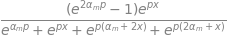

In [2]:
x = sym.Symbol('x')
p = sym.Symbol('p')
f = sym.Symbol('f')
C_l = sym.Symbol('C_l')
alpha_m = sym.Symbol('alpha_m')

C_L = (1/p*sym.ln((1+sym.exp(p*(x+alpha_m)))/(1+sym.exp(p*(x-alpha_m))))-alpha_m)
sym.simplify(C_L.diff(x))

In [3]:
def Model_0(b_modes,t_modes):
    return rwm.GenRectWingModel(b_modes,t_modes,fwt_free=False,iwt=True,iwb=False,aero_model=rwm.AeroModel.LiftOnly)
def Model_1(b_modes,t_modes):
    return rwm.GenRectWingModel(b_modes,t_modes,fwt_free=True,iwt=False,iwb=False,aero_model=rwm.AeroModel.LiftOnly)
def Model_2(b_modes,t_modes):
    return rwm.GenRectWingModel(b_modes,t_modes,fwt_free=True,iwt=True,iwb=False,aero_model=rwm.AeroModel.LiftOnly)
def Model_3(b_modes,t_modes):
    return rwm.GenRectWingModel(b_modes,t_modes,fwt_free=True,iwt=True,iwb=True,aero_model=rwm.AeroModel.LiftOnly)
def Model_4(b_modes,t_modes):
    return rwm.GenRectWingModel(b_modes,t_modes,fwt_free=True,iwt=True,iwb=True,aero_model=rwm.AeroModel.LiftOnly_rot)
def Model_5(b_modes,t_modes):
    return rwm.GenRectWingModel(b_modes,t_modes,fwt_free=True,iwt=True,iwb=True,aero_model=rwm.AeroModel.LiftAndDrag_rot)
def Model_6(b_modes,t_modes):
    model,p = Model_4(b_modes,t_modes)
    return model.linearise(p).msubs({i:0 for i in p.fp}),p
def Model_7(b_modes,t_modes):
    model,p = Model_5(b_modes,t_modes)
    return model.linearise(p).msubs({i:0 for i in p.fp}),p
def Model_8(b_modes,t_modes):
    model,p = rwm.GenRectWingModel(b_modes,t_modes,fwt_free=True,iwt=True,iwb=False,aero_model=rwm.AeroModel.LiftOnly_rot)
    return model.linearise(p).msubs({i:0 for i in p.fp}),p

ModelFactory = {
    0:Model_0,
    1:Model_1,
    2:Model_2,
    3:Model_3,
    4:Model_4,
    5:Model_5,
    6:Model_6,
    7:Model_7,
    8:Model_8
}


def MakeModel(k,v,b_modes,t_modes):
    print(k)
    model,p = v(b_modes,t_modes)
    model.to_file(f'{b_modes}B{t_modes}T-M{k}.py')
    print(k)
    return k

In [ ]:
b_modes = 3
t_modes = 3


pool = mp.Pool(mp.cpu_count())


for k,v in ModelFactory.items():
    pool.apply_async(MakeModel,args=(k,v,b_modes,t_modes))
pool.close()
pool.join()

0
4
1
2
5
3
6
7
8
3


In [5]:
#%%time
for i in range(9):
    %time MakeModel(i,ModelFactory[i],3,3)
#%time MakeModel(0,Model_0,3,3)
#%time MakeModel(5,Model_5,3,3)

In [4]:
#%%time 
%time MakeModel(0,Model_0,3,3)
%time MakeModel(5,Model_5,3,3)

CPU times: user 35.3 s, sys: 189 ms, total: 35.5 s
Wall time: 35.7 s
CPU times: user 49.7 s, sys: 217 ms, total: 49.9 s
Wall time: 50.1 s


In [22]:
sm = mf.SymbolicModel.from_file('3B3T-M5.py')

In [24]:
p = rw.base_params(7)
nm = sm.CreateNumericModel(p)

In [5]:
%%time
sm = mf.SymbolicModel.from_file('3B3T-M5.py')
p = rw.base_params(7)
sm.linearise(p)

In [34]:
%%timeit -n 100 -r 1
y0 = [0]*7*2
t = 0
nm.M_func(p.GetNumericTuple(y0,t),y0)

81.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


In [36]:
%%timeit -n 100 -r 1
y0 = [0]*7*2
t = 0
nm.ExtForces(p.GetNumericTuple(y0,t),y0,0)

140 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


In [33]:
%%time
sm = mf.SymbolicModel.from_file('3B3T-M1.py')
p = rw.base_params(7)
sm.linearise(p)

CPU times: user 10.8 s, sys: 49.8 ms, total: 10.9 s
Wall time: 10.9 s
